# 심화과제 1: CNN Visualization


이번 과제에서는 강의에서 공부했던 다양한 방식의 CNN visualization 방법들을 직접 구현해봅니다. 기본과제3 에서 구현했던 VGG-11을 분석해보며 CNN의 동작과 학습 원리에 대한 좋은 직관을 갖게 되셨으면 좋겠습니다. 

과제 목표: 
- 기학습된 모델을 분석하는 방법, 조작하는 방법들에 대해서 익힌다.
- 모델 디버깅에 필요한 기본 방법들에 대해서 숙지 한다.
- 그레디언트 정보가 포함하고 있는 의미를 이해하고, 이를 분석해 활용할 수 있도록 한다.


Special thanks: This PA design is inspired from PA5 of Cornell CS5670 (By Noah Snavely and Abe Davis). 

## **Notes on PyTorch**
Many operations are implemented on Tensors (e.g, torch.FloatTensor or torch.LongTensor) in PyTorch, as on ndarray in numpy. One can compute operations like arithmetics, and will get a new Tensor as an output. 

Also, Variables (e.g, torch.autograd.Variable) wrap tensors and can be used interchangeably as Tensors. Like Tensors, with operation on Variable, the output is a new Variable.

Here, Pytorch autograd builds a computational graph with operations on Tensors (involving Variables), with True requires_grad parameter. This indicates to compute gradients of that Tensors w.r.t. the other Tensors 'automatically' with calling backward. 

With such option, one can calculate the gradient w.r.t. model parameters by calling backward on the loss function we're trying to optimize, allowing us to implement 'gradient descent'. Furthremore, one can call backward to calculate the gradient w.r.t the input. 

One can access to the gradients (after calling backward) as the .grad attribute of the Tensor.

##**Data Download**
해당 문제를 풀기 위해서는 (1) pretrained model 과 (2) 저희가 선별한 inference용도의 data가 따로 필요합니다. 아래의 명령어를 통해 과제 해결에 필요한 파일들을 colab session에 다운로드하고 압축을 해제해주세요.

    
***Inference를 위해 사용하는 data에는 저작권 문제가 있으니, 과제 해결 이외의 작업에는 절대로 사용하시면 안됩니다.***

In [1]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5" -O files.zip && rm -rf ~/cookies.txt

--2022-03-11 03:43:04--  https://docs.google.com/uc?export=download&confirm=t&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5
Resolving docs.google.com (docs.google.com)... 142.250.199.110, 2404:6800:4004:823::200e
Connecting to docs.google.com (docs.google.com)|142.250.199.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oa30hv9hhonvnbmo3dqspdnsjogo1vdb/1646970150000/09977954582062536659/*/1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5?e=download [following]
--2022-03-11 03:43:04--  https://doc-04-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oa30hv9hhonvnbmo3dqspdnsjogo1vdb/1646970150000/09977954582062536659/*/1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5?e=download
Resolving doc-04-3g-docs.googleusercontent.com (doc-04-3g-docs.googleusercontent.com)... 172.217.175.97, 2404:6800:4004:81f::2001
Connecting to doc-04-3g-docs.googleusercontent.com (doc-04-3g-docs.g

In [2]:
!unzip files.zip

Archive:  files.zip
  inflating: data/1.jpg              
  inflating: data/0.jpg              
  inflating: model.pth               


## **Utils**
과제 해결에 필요한 여러가지 함수들입니다.

### Utils (module)

In [3]:
from os import path
import wheel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import functools
import urllib
import cv2
import numpy as np
import os
import sys
import math
import random
import matplotlib.pyplot as plt
from glob import glob
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO

import PIL.Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Utils (image converter)

In [4]:
def image_tensor_to_numpy(tensor_image):
  # If this is already a numpy image, just return it
  if type(tensor_image) == np.ndarray:
    return tensor_image
  
  # Make sure this is a tensor and not a variable
  if type(tensor_image) == Variable:
    tensor_image = tensor_image.data
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor_image.detach().cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img

def image_numpy_to_tensor(np_image):
  if len(np_image.shape) == 3:
    np_image = np_image[np.newaxis, ...]
  
  # Convert from BxHxWxC (OpenCV/numpy) to BxCxHxW (PyTorch)
  np_image = np_image.transpose(0, 3, 1, 2)
  
  tensor_image = torch.from_numpy(np_image).float()
  
  return tensor_image

### Utils (image drawer)

In [5]:
def normalize(tensor):
  x = tensor - tensor.min()
  x = x / (x.max() + 1e-9)
  return x

def draw_border(image_np, color):
  color = np.asarray(color)
  s = image_np.shape
  image_np = image_np.copy()
  image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
  image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
  return image_np

def show_image(image, title=None):
  np_img = image_tensor_to_numpy(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize(np_img)
  
  # plot 
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()
    
def show_images(image_list):
  for l in image_list:
    f, axarr = plt.subplots(1,len(l))
    for i,img in enumerate(l):
      np_img = image_tensor_to_numpy(img)
      if len(np_img.shape) > 3:
        np_img = np_img[0]
      np_img = normalize(np_img)

      np_img = np_img.squeeze()
      axarr[i].imshow(np_img)
      axarr[i].axis('off')
    plt.show()

## **Model definition**
이전 과제에서 구현하였던 VGG-11의 코드입니다.

In [6]:
class VGG11BackBone(nn.Module):
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

class VGG11Classification(nn.Module):
  def __init__(self, num_classes = 7):
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.gap      = nn.AdaptiveAvgPool2d(1)
    self.fc_out   = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.backbone.pool5(x)

    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

In [7]:
model_root = './model.pth'

model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

<All keys matched successfully>

## **Dataset**

과제 수행을 위한 dataset 코드입니다.

In [8]:
# Dataset
class MaskDataset(Dataset):
  def __init__(self, data_root, input_size=224, transform=None, shuffle=False):
    super(MaskDataset, self).__init__()

    self.img_list = sorted(glob(os.path.join(data_root, '*.jpg')))
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
  
    # Image Loading
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.

    if self.transform:
      img = self.transform(img)

    return img

  def __len__(self):
    return self.len

In [9]:
data_root = './data'

input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

mask_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)

## **Problem 2-1**

아래는 학습된 VGG-11를 visualization하는 코드입니다. 
총 3개의 **TO DO**를 채워보세요.


- **TO DO (1)**: 주어진 모듈의 parameter 개수를 return하는 **get_params_num** 코드를 완성해주세요.

- **TO DO (2)**: 모델에서 **conv1_filters_data**를 얻는 코드를 완성해주세요.

- **TO DO (3)**: Activation을 target layer에 시각화하기 위해 hook function을 register해주세요.

- **Hint**: 아래의 코드를 이용해보세요.    
(1) [module.register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html) \
(2) Tensor.weight.data    
(3) torch.size()    


### **Visualizing Structure**
VGG-11의 구조를 각 layer의 weights shape을 통해 확인해봅시다.
예를 들어, input channel의 32이고 output channel이 64인 3x3 convolution layer라면 (64, 32, 3, 3)의 weight shape 가집니다.

In [10]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

for name, module in model.named_parameters():
  names = name.split(".")
  if "backbone" in name:
    n = names[1]
  else:
    n = names[0]

  if "weight" in name :
    print(f"** Module {n} **\n"
          f"weights: {module.size()}")
  if "bias" in name :
    print(f"bias: {module.size()}\n")

** Module conv1 **
weights: torch.Size([64, 3, 3, 3])
bias: torch.Size([64])

** Module bn1 **
weights: torch.Size([64])
bias: torch.Size([64])

** Module conv2 **
weights: torch.Size([128, 64, 3, 3])
bias: torch.Size([128])

** Module bn2 **
weights: torch.Size([128])
bias: torch.Size([128])

** Module conv3_1 **
weights: torch.Size([256, 128, 3, 3])
bias: torch.Size([256])

** Module bn3_1 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv3_2 **
weights: torch.Size([256, 256, 3, 3])
bias: torch.Size([256])

** Module bn3_2 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv4_1 **
weights: torch.Size([512, 256, 3, 3])
bias: torch.Size([512])

** Module bn4_1 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv4_2 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

** Module bn4_2 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv5_1 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

*

아래의 **get_module_params_num**의 **TO DO (1)** 부분에서 각 layer의 parameter의 크기를 *param_num* 변수에 더하여 총 parameter의 개수를 구할 수 있도록 코드를 완성해주세요.

In [13]:
def get_module_params_num(module):
  """
  Return the parameter number of modules
  With parameter in module in shape of (H,W,D), the size of such parameter would be HxWxD

  Keyword arguments:
  module: the module is composed of several named parameters
  """
  param_num = 0

  for _, param in module.named_parameters():
    
    '''==========================================================='''
    '''======================== TO DO (1) ========================'''

    param_size = 1
    # print(list(param.size()))
    for i in list(param.size()):
        param_size *= i
    param_num += param_size

    '''==========================================================='''
    '''======================== TO DO (1) ========================'''

  return param_num

def get_model_params_num(model):
  module_num = 0
  for name, module in model._modules.items():
    module_num += get_module_params_num(module)
  return module_num

In [14]:
num_params = get_model_params_num(model)
print(f"Number of parameters in customed-VGG11: {num_params}")

Number of parameters in customed-VGG11: 9229575


### **Visualizing conv1 filters**

첫번째 convolution layer는 RGB 형태의 input image을 받기 때문에, 해당 filters의 입력 채널 수가 RGB 채널 수와 같기 때문에, filter를 <!-- 해당 filters를  --> 
RGB image로 변환하여 시각화할 수 있습니다. (이후 레이어의 다른 filters는 high dimension을 갖고 있기 때문에 첫번째 convolution layer에 비해 시각화가 어렵습니다.)

첫번째 convolution layer의 filter를 시각화하기 위하여 해당 layer의 weight를 *conv1_filters_data* 변수에 할당하는 코드를 **TO DO (2)** 부분에 완성해주세요. 전체 모델에서 원하는 레이어의 이름을 **print(model)**을 통해 확인한 다음 해당 layer의 weight를 Tensor로 얻는 과정입니다.

In [15]:
def plot_filters(data, title=None):
    """
    Take a Tensor of shape (n, K, height, width) or (n, K, height, width)
    and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    """
    
    if data.size(1) > 3:
      data = data.view(-1, 1, data.size(2), data.size(3))
        
    data = image_tensor_to_numpy(data)
        
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 2), (0, 2))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = data.squeeze()
    
    # plot it
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(title)
    plt.imshow(data)

In [16]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

print(model)

VGG11Classification(
  (backbone): VGG11BackBone(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, 

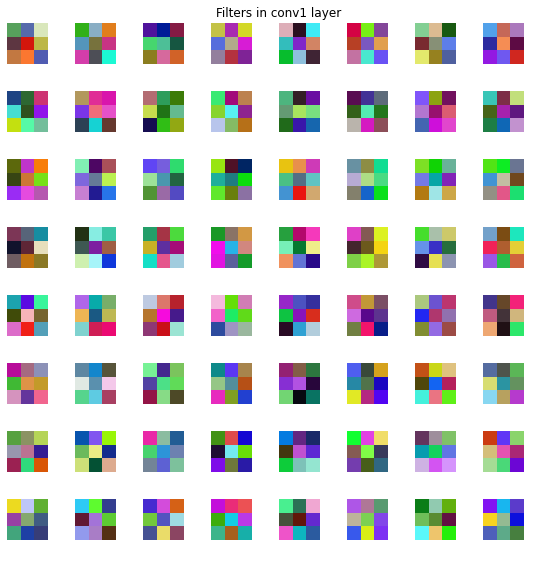

In [17]:
'''==========================================================='''
'''======================== TO DO (2) ========================'''

conv1_filters_data = model.backbone.conv1.weight.data

'''==========================================================='''
'''======================== TO DO (2) ========================'''

plot_filters(conv1_filters_data, title="Filters in conv1 layer")

### **Visualizing model activations**
Pytorch에서는 hook을 통해서 모델의 최종 출력값이 아닌 중간 layer들의 출력값을 얻을 수 있는 편리한 기능을 제공합니다.
<!-- 있습니다. -->
 모델의 중간의 원하는 부분에 갈고리(hook)를 건 다음, 해당 layer의 출력을 건져올린다고 이해하시면 좋을 것 같습니다.

예를 들어, forward hook은 각 module에 대해 forward method가 실행될 때마다 설정한 function이 실행됩니다. 따라서 forward hook에 visualization function을 설정하면 각 layer의 activation을 시각화할 수 있습니다.

In [18]:
plot_activations = plot_filters

In [19]:
activation_list = []

def show_activations_hook(name, module, input, output):
  # conv/relu layer outputs (BxCxHxW)
  if output.dim() == 4:
    activation_list.append(output)
    plot_activations(output, f"Activations on: {name}")

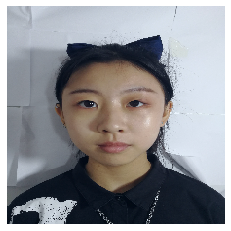

In [20]:
# Image preparation
img = mask_dataset[0]
show_image(img)
img = Variable(img[np.newaxis, ...])
img = img.double()

위에서 선언한 **show_activations_hook** 함수를 이용하여 각 module에 forward hook을 걸어주어 layer의 출력값을 시각화해주세요. 

- Tip 1. module에 forward hook을 걸어주기 위해서는 module.register_forward_hook을 이용하세요. \
- Tip 2. 함수의 일부 인자가 채워진 상태로 호출하고 싶다면 [functools.partial](https://hamait.tistory.com/823)을 이용해보세요.

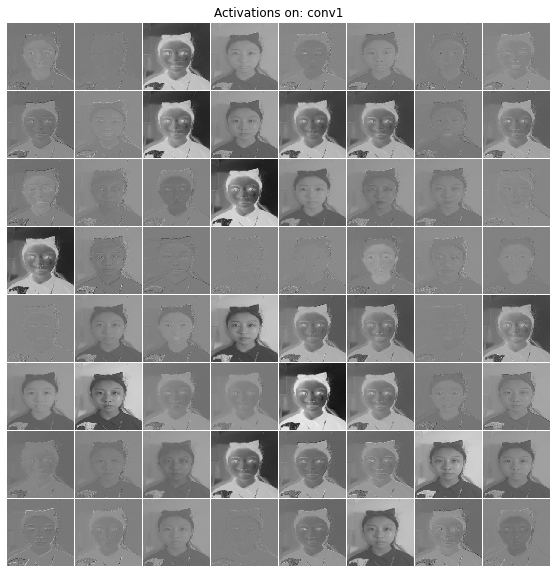

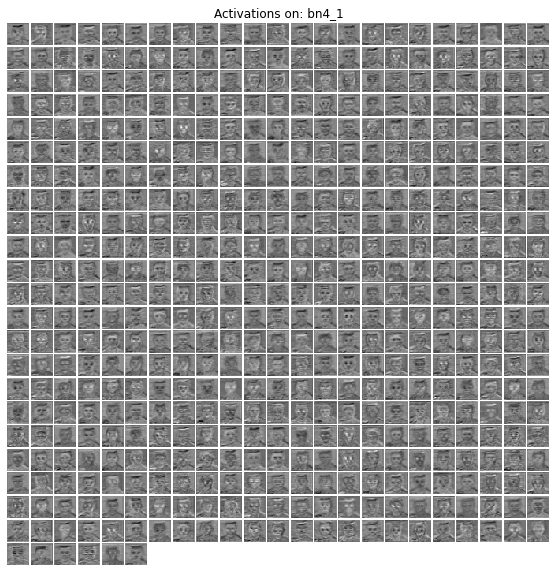

In [21]:
# Re-define the model to clear any previously registered hooks
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

# Register the hook on the select set of modules
module_list  = [model.backbone.conv1, model.backbone.bn4_1]
module_names = ["conv1", "bn4_1"]

# You may use functools.partial to make function already filled with target module name
for idx, (name, module) in enumerate(zip(module_names, module_list)):
  '''==========================================================='''
  '''======================== TO DO (3) ========================'''

  hook = functools.partial(show_activations_hook, name)
  module.register_forward_hook(hook)## FILE ME ##

  '''==========================================================='''
  '''======================== TO DO (3) ========================'''

_ = model(img)

In [22]:
np.shape(activation_list[0])

torch.Size([1, 64, 224, 224])

#### **Discussion**

You may analyze activations in different modules by modifying **module_list**. Check how different activations are between layers near input and near output.

## **Problem 2-2**

아래는 saliency map을 시각화하는 코드입니다. Saliency map이란, CNN이 최종 결과를 내리기까지 각 pixel이 기여하고 있는 정도를 시각화하여 나타낸 것으로 activation map이라고도 불립니다. [참고 자료](https://www.geeksforgeeks.org/what-is-saliency-map/). 

- **TO DO (4)**: Input image에 대한 gradient s_y (the score at index class_idx)를 return하는 함수 **compute_gradient_score**를 완성해주세요.


- **Hint**: 원하는 gradient를 얻기 위해 어떤 정보가 back-propagate 되어야 하는지를 생각해보세요! (ds_y / dI).

### **Visualizing saliency**
학습된 customed-VGG11을 이용하여 [1]의 Section 3.1을 따라 class saliency maps을 얻을 수 있습니다. 논문의 Section 2를 바탕으로, 이미지의 class score에 대한 gradient를 계산할 수 있습니다. 

아래의 코드에서 계산하고자 하는 식을 아래와 같습니다.:$${\partial s_y \over \partial I}$$

이때 $s_y$는 class $y$에 대한 logit입니다. (fully connected layer를 통과한 다음, 즉 softmax layer를 통과하기 이전의 값).

Gradient를 계산한 다음에, 해당 값들을 시각화함으로써 input image에 대한 saliency를 확인할 수 있습니다. 자세한 내용은 아래 논문의 본문을 참고해주세요!

[[1] Simonyan et al., Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps, ICLR 2014](https://arxiv.org/pdf/1312.6034.pdf)




In [ ]:
def compute_gradient_score(scores, image, class_idx):
    """
    Returns the gradient of s_y (the score at index class_idx) w.r.t the input image (data), ds_y / dI. 

    class_idx에 해당하는 class에 대한 gradient인 s_y를 계산해야 합니다.
    전체 class의 개수의 길이를 갖는 scores에서 원하는 index의 score를 s_y로 얻은 다음, 해당 s_y를 back-propagate하여 gradient를 계산하는 코드를 완성해주세요.
    """
    grad = torch.zeros_like(image)

    '''==========================================================='''
    '''======================== TO DO (4) ========================'''

    s_y = scores[class_idx]
    s_y.backward() ## FILE ME ##

    '''==========================================================='''
    '''======================== TO DO (4) ========================'''

    grad = image.grad
    assert tuple(grad.shape) == (1, 3, 224, 224)

    return grad[0]

In [ ]:
def visualize_saliency(image, model):
    input = Variable(image.unsqueeze(0), requires_grad=True)
    output = model(input)[0]
    max_score, max_idx = torch.max(output, 0)

    grad = compute_gradient_score(output, input, max_idx)

    vis = grad ** 2
    vis, _ = torch.max(vis, 0)
    
    return vis

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

input_images = []
saliency_maps = []
  
for _, sample in enumerate(mask_dataset):
  saliency_map = visualize_saliency(sample, model)
  assert list(saliency_map.shape) == [224, 224]
    
  saliency_maps.append(saliency_map.unsqueeze(0))
  input_images.append(sample)

row_list = list(zip(input_images, saliency_maps))
show_images(row_list)

## **Problem 2-3**

아래는 Grad-CAM을 시각화하기 위한 코드입니다. 2개의 **TO DO**s를 채워주세요.


- **TO DO (5)**: 함수 **vis_gradcam**을 완성해주세요. (1) Layer의 activation을 저장할 function을 hook하고 (2) forward하고 (3) gradients를 저장하기 위해 hook을 register한 다음 (4) 출력에 대한 최댓값에 해당하는 score를 backward해야 합니다. (1) - (3) - (2) - (4)의 순서로 Grad-CAM을 시각화할 수 있습니다.


- **TO DO (6)**: 함수 **vis_gradcam**을 완성해주세요. 아래의 텍스트에 설명되어 있는 **Grad-CAM**의 값을 계산한 다음 (2) 원본 이미지의 크기에 맞게 upsampling 해야합니다.


### **Visualizing Grad-CAM**

Saliency map을 시각화하기 위하여, [2]의 Section 3.1을 따라 Grad-CAM을 얻을 수 있습니다. 

첫번째로 $\alpha_c^k$를 다음 과정으로 계산합니다: $${\partial y^c \over \partial A^k}$$

이때 $y^c$는 class $c$에 대한 score이고 $A^k$는 target layer인 $k$-th feature map의 activation입니다.

다음으로 $\alpha_c^k$를 weights로 하여 forward activation maps $A$의 weighted sum을 얻고 $ L_{Grad-CAM}^c $ (i.e, $ ReLU (\sum_k \alpha_c^k A^k) $)을 얻기 위하여 ReLU를 통과합니다.


[[2] Selvaraju et al., Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, ICCV 2017](https://arxiv.org/abs/1610.02391)

In [ ]:
save_feat=[]
def hook_feat(module, input, output):
  save_feat.append(output)
  return output


save_grad=[]
def hook_grad(grad):
  """
  get a gradient from intermediate layers (dy / dA).
  See the .register-hook function for usage.
  :return grad: (Variable) gradient dy / dA
  """ 
  save_grad.append(grad)
  return grad


def vis_gradcam(vgg, img):
  """
  Imshow the grad_CAM.
  :param vgg: VGG11Customed model
  :param img: a dog image
  output : plt.imshow(grad_CAM)
  """
  vgg.eval()


  '''==========================================================='''
  '''======================== TO DO (5) ========================'''
  # (1) Reister hook for storing layer activation of the target layer (bn5_2 in backbone)
  vgg.backbone.## FILE ME ##
  
  # (2) Forward pass to hook features
  img = img.unsqueeze(0)
  s = ## FILE ME ##

  # (3) Register hook for storing gradients
  save_feat[0].## FILE ME ##
  
  # (4) Backward score
  y = ## FILE ME ##
  s_y = ## FILE ME ##
  s_y.## FILE ME ##

  '''==========================================================='''
  '''======================== TO DO (5) ========================'''



  # Compute activation at global-average-pooling layer
  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0].squeeze())
  A = save_feat[0].squeeze()



  '''==========================================================='''
  '''======================== TO DO (6) ========================'''
  # (1) Compute grad_CAM 
  # (You may need to use .squeeze() to feed weighted_sum into into relu_layer)
  relu_layer = ## FILE ME ##

  weighted_sum = ## FILE ME ##
  grad_CAM = ## FILE ME ##

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  # (2) Upscale grad_CAM
  # (You may use defined upscale_layer)
  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')

  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = ## FILE ME ##


  '''==========================================================='''
  '''======================== TO DO (6) ========================'''



  # Plotting
  img_np = image_tensor_to_numpy(img)
  if len(img_np.shape) > 3:
    img_np = img_np[0]
  img_np = normalize(img_np)
  
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(img_np)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
  plt.show

  return grad_CAM

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

img = mask_dataset[1]
res = vis_gradcam(model, img)

#### **Discussion**

- 기본 과제 3번의 **segmentation model**의 결과와 이번 과제의 **Grad-CAM**의 결과를 비교해보세요. 어떤 점이 비슷하고 어떤점이 다른지를 위주로 생각해보세요!
두 과제는 밀접한 연관을 가지고 기획 되었습니다. GradCAM의 Gradient가 classification to segmentation 에서 어떤 요소와 유사성을 가지고 있는지 수식을 유도해 보기 바랍니다.
<!-- 선택 과제 1번의 **segmentation model**의 결과와 **Grad-CAM**의 결과를 비교해보세요. 어떤 점이 비슷하고 어떤점이 다른지를 위주로 생각해보세요!  -->

- 위 Problem 2-2에서 언급한 Gradient가 class에 대한 saliency 정보를 포함하게 되는 이유에 대해서 고찰해 보세요.